<figure>
<img src="../Imagenes/logo-final-ap.png"  width="80" height="80" align="left"/> 
</figure>

# <span style="color:blue"><left>Aprendizaje Profundo</left></span>

# <span style="color:red"><center>Autoencoder para colorear imagenes</center></span>

**<center>Convolucional autoencoder</center>**

##   <span style="color:blue">Profesores</span>

1. Alvaro Mauricio Montenegro Díaz, ammontenegrod@unal.edu.co
2. Daniel Mauricio Montenegro Reyes, dextronomo@gmail.com 
3. Campo Elías Pardo Turriago, cepardot@unal.edu.co 

##   <span style="color:blue">Asesora Medios y Marketing digital</span>
 

4. Maria del Pilar Montenegro, pmontenegro88@gmail.com 

## <span style="color:blue">Asistentes</span>

5. Oleg Jarma, ojarmam@unal.edu.co 
6. Laura Lizarazo, ljlizarazore@unal.edu.co 

## <span style="color:blue">Referencias</span>

1. Basadado en Rowel Atieza, [Advanced Deep Learning with TensorFlow 2 and Keras](https://www.amazon.com/-/es/Rowel-Atienza-ebook/dp/B0851D5YQQ), 2020.

## <span style="color:blue">Contenido</span>

* [Introducción](#Introducción)
* [Importa módulos](#Importa-módulos)
* [ Función para convertir una imagen a color en tonos de gris](#Función-para-convertir-una-imagen-a-color-en-tonos-de-gris)
* [Los datos](#Los-datos)
* [Configuración](#Configuración)
* [Encoder](#Encoder)
* [Decoder](#Decoder)
* [Autoencoder](#Autoencoder)
* [Callbacks](#Callbacks)
* [Compila](#Compila)
* [Entrena](#Entrena)
* [Predicciones y gráficas](#Predicciones-y-gráficas)

## <span style="color:blue">Introducción </span>

Construimos un autoencoder para colorear imágenes en tonos de grises

## <span style="color:blue">Importa módulos </span>

In [45]:
import numpy as np 
import matplotlib.pyplot as plt 
import os
  
from tensorflow.keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint 
from tensorflow.keras.datasets import cifar100 
from tensorflow.keras.utils import plot_model

## <span style="color:blue">Función para convertir una imagen a color en tonos de gris </span>

In [2]:
def rgb_2_gray(image): 
    return np.dot(image[..., :3], [0.299, 0.587, 0.114]) 

## <span style="color:blue">Los datos</span>

Los datos son de la base [Cifar](https://www.cs.toronto.edu/~kriz/cifar.html) creados en la Universidad de Toronto.

### Lee datos

In [3]:
(x_train, _), (x_test, _) = cifar100.load_data() 
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


### Crea imágenes en escala de grises

In [5]:
x_train_gray = x_train[..., :3]@[0.299, 0.587, 0.114]
x_test_gray  = x_test[..., :3]@[0.299, 0.587, 0.114]

# Reshape to the model
x_train_gray = np.expand_dims(x_train_gray , axis=3)
x_test_gray = np.expand_dims(x_test_gray, axis=3)

print(x_train_gray.shape)
print(x_test_gray.shape)

(50000, 32, 32, 1)
(10000, 32, 32, 1)


### Normaliza datos

In [6]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
  
x_train_gray = x_train_gray.astype('float32') / 255.
x_test_gray = x_test_gray.astype('float32') / 255.

## <span style="color:blue">Configuración</span>

In [80]:
rows = x_train.shape[1]
cols = x_train.shape[2]
channels = x_train.shape[3]

input_shape = (rows, cols, 1) 
batch_size = 256
kernel_size = 3
latent_dim = 512
layer_filters = [64, 128, 256] 
dropout_rate = 0.2

## <span style="color:blue">Encoder</span>

In [81]:
inputs = Input(shape = input_shape) 
x = inputs 
for filters in layer_filters: 
    x = Conv2D(filters = filters, 
               kernel_size = kernel_size, 
               strides = 2, 
               activation ='relu', 
               padding ='same')(x) 
    x = Dropout(dropout_rate)(x)
# Save the shape to the decoder
shape = x.shape.as_list()
# shape = shape[1:]

x = Flatten()(x) 
x = Dropout(dropout_rate)(x)
latent = Dense(latent_dim, name ='latent_vector')(x) 
encoder_colorizing = Model(inputs, latent, name ='encoder_colorizing') 

### Summary

In [82]:
encoder_colorizing.summary()
plot_model(encoder_colorizing, to_file='./encoder_colorizing.png',show_shapes=True)

Model: "encoder_colorizing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 16, 16, 64)        640       
_________________________________________________________________
dropout_28 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
dropout_29 (Dropout)         (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 4, 4, 256)         295168    
_________________________________________________________________
dropout_30 (Dropout)         (None, 4, 4, 256)  

## <span style="color:blue">Decoder</span>

In [83]:
latent_inputs = Input(shape =(latent_dim, ), name ='decoder_input') 
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs) 
x = Reshape((shape[1], shape[2], shape[3]))(x) 
# stack of Conv2DTranspose(256)-Conv2DTranspose(128)- 
# Conv2DTranspose(64) 
for filters in layer_filters[::-1]: 
    x = Conv2DTranspose(filters = filters, 
                        kernel_size = kernel_size, 
                        strides = 2, 
                        activation ='relu', 
                        padding ='same')(x)
    x = Dropout(dropout_rate)(x)

outputs = Conv2DTranspose(filters = channels , 
                          kernel_size = kernel_size, 
                          activation ='sigmoid', 
                          padding ='same', 
                          name ='decoder_output')(x)
x = Dropout(dropout_rate)(x)
decoder_colorizing = Model(latent_inputs, outputs, name ='decoder_colorizing') 

In [76]:
for filters in layer_filters: 
  x = Conv2D(filters = filters, 
           kernel_size = kernel_size, 
           strides = 2, 
           activation ='relu', 
           padding ='same')(x) 

### Summary

In [84]:
decoder_colorizing.summary()
plot_model(decoder_colorizing, to_file='./decoder_colorizing.png',show_shapes=True)

Model: "decoder_colorizing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 512)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              2101248   
_________________________________________________________________
reshape_4 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_15 (Conv2DT (None, 8, 8, 256)         590080    
_________________________________________________________________
dropout_32 (Dropout)         (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 16, 16, 128)       295040    
_________________________________________________________________
dropout_33 (Dropout)         (None, 16, 16, 128)

## <span style="color:blue">Autocoder</span>

In [85]:
autoencoder_colorizing = Model(inputs, decoder_colorizing(encoder_colorizing(inputs)), 
                    name ='autoencoder_colorizing') 

### Summary

In [86]:
autoencoder_colorizing.summary()
plot_model(autoencoder_colorizing, to_file='./autoencoder_colorizing.png',show_shapes=True)

Model: "autoencoder_colorizing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 32, 32, 1)]       0         
_________________________________________________________________
encoder_colorizing (Function (None, 512)               2467328   
_________________________________________________________________
decoder_colorizing (Function (None, 32, 32, 3)         3061891   
Total params: 5,529,219
Trainable params: 5,529,219
Non-trainable params: 0
_________________________________________________________________
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


## <span style="color:blue">Callbacks</span>

In [88]:
# prepare model saving directory.
save_dir = os.path.join(os.getcwd(), '../saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)


# called every epoch
callbacks = [lr_reducer, checkpoint]

## <span style="color:blue">Compila</span>

In [90]:
autoencoder_colorizing.compile(loss= 'mse',
                  optimizer= 'adam',
                   metrics=['mae'])

## <span style="color:blue">Entrena</span>

autoencoder_colorizing.fit(x_train_gray, 
                x_train, 
                validation_data =(x_test_gray, x_test), 
                epochs = epochs, 
                batch_size = batch_size) 

In [91]:
epochs = 20

history=autoencoder_colorizing.fit(x_train_gray,
                x_train,
                validation_data=(x_test_gray, x_test),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks)

Epoch 1/20
196/196 [==============================] - 92s 465ms/step - loss: 0.0454 - mae: 0.1677 - val_loss: 0.0191 - val_mae: 0.1041

Epoch 00001: val_loss improved from inf to 0.01912, saving model to /home/bizon/Documents/Diplomado IA y AP/Diplomado-master/Temas/Módulo 6- Autocodificadores/1. Autocodificadores generales/Cuadernos/../saved_models/colorized_ae_model.001.h5
Epoch 2/20
196/196 [==============================] - 91s 462ms/step - loss: 0.0189 - mae: 0.1019 - val_loss: 0.0168 - val_mae: 0.0951

Epoch 00002: val_loss improved from 0.01912 to 0.01677, saving model to /home/bizon/Documents/Diplomado IA y AP/Diplomado-master/Temas/Módulo 6- Autocodificadores/1. Autocodificadores generales/Cuadernos/../saved_models/colorized_ae_model.002.h5
Epoch 3/20
196/196 [==============================] - 91s 463ms/step - loss: 0.0166 - mae: 0.0940 - val_loss: 0.0144 - val_mae: 0.0858

Epoch 00003: val_loss improved from 0.01677 to 0.01437, saving model to /home/bizon/Documents/Diplomado 

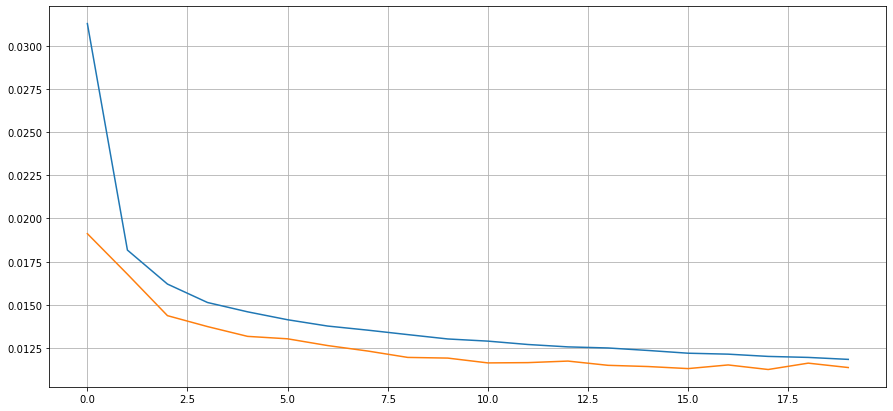

In [92]:
plt.figure(figsize=(15,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.show()

## <span style="color:blue">Predicciones y gráficas</span>

In [93]:
x_decoded = autoencoder_colorizing.predict(x_test_gray)

### Imágenes originales

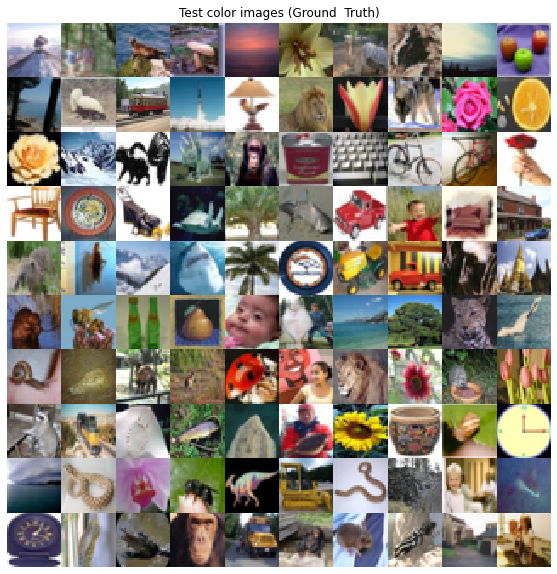

In [68]:
# display the 1st 100 input images (color and gray)

img_rows = rows
img_cols = cols

imgs_t = x_test[:100]
imgs_t = imgs_t.reshape((10, 10, img_rows, img_cols, channels))
imgs_t = np.vstack([np.hstack(i) for i in imgs_t])
plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs_t, interpolation='none')
plt.savefig('./test_color.png')
plt.show()

### Imágenes en escala de grises

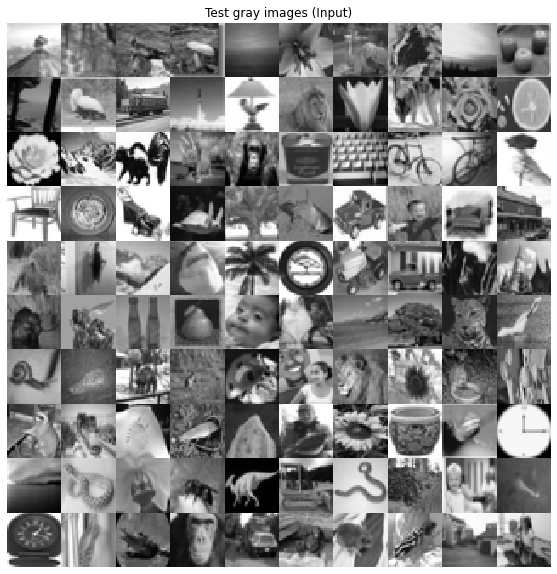

In [21]:
# display grayscale version of test images
imgs_g = x_test_gray[:100]
imgs_g = imgs_g.reshape((10, 10, img_rows, img_cols))
imgs_g = np.vstack([np.hstack(i) for i in imgs_g])
plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs_g, interpolation='none', cmap='gray')
plt.savefig('./test_gray.png')
plt.show()

### Primeras 100 imágenes coloreadas

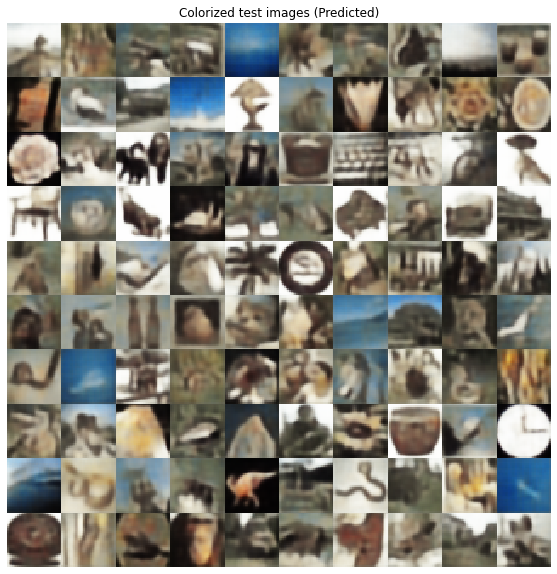

In [95]:
# display the 1st 100 colorized images
imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])

plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.savefig('./colorized.png')

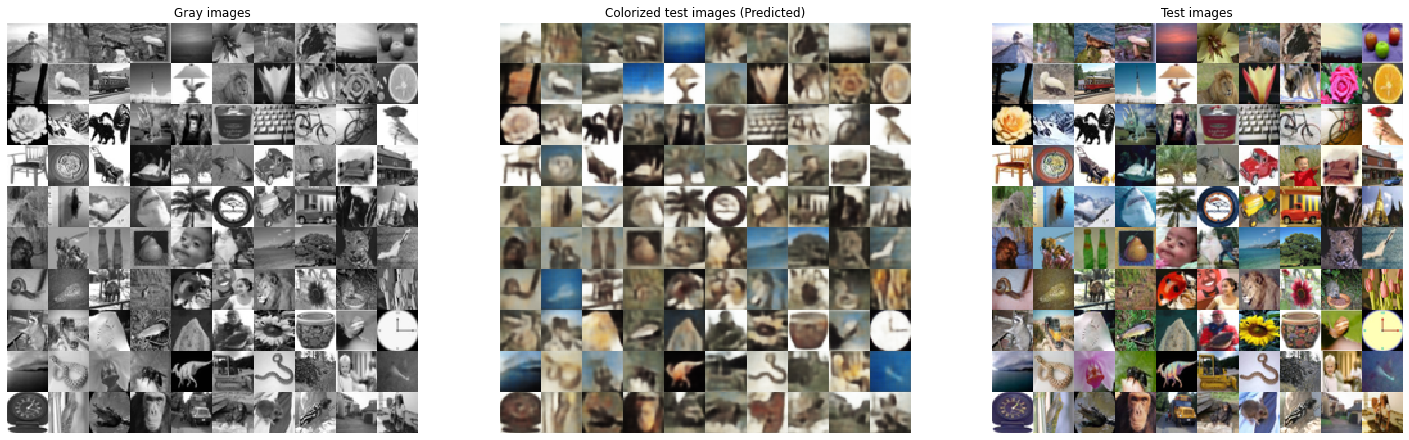

In [96]:
plt.figure(figsize=(25,25))
plt.subplot(131)
plt.axis('off')
plt.title('Gray images')
plt.imshow(imgs_g, interpolation='none',cmap='gray')
plt.savefig('./test.png')

plt.subplot(132)
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.savefig('./colorized.png')

plt.subplot(133)
plt.axis('off')
plt.title('Test images')
plt.imshow(imgs_t, interpolation='none')
plt.savefig('./test.png')

plt.show()